In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

####Loading the data

In [7]:
path = "/content/sample_data/creditcard.csv"

try:
  df = pd.read_csv(path)
  print("Data set is loaded")
  print("Shape ", df.shape)
except FileNotFoundError:
  print("File not found")

Data set is loaded
Shape  (7973, 31)


In [10]:
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0.0
1,0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0.0
2,1,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0.0
3,1,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0.0
4,2,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0.0


####EDA and Sanity Check

In [16]:
missing_vals = df.isnull().sum()
missing_vals

,0
Time,0
V1,0
V2,0
V3,0
V4,0
V5,0
V6,0
V7,0
V8,0
V9,0


In [20]:
df[df.isnull().any(axis=1)]

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
7972,10981,1.145381,-0.059349,0.968088,0.267891,-0.822582,-0.597727,-0.450197,-0.119747,1.338188,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [22]:
df = df.dropna()
df.isna().sum().sum()

np.int64(0)

In [25]:
fraud_count = df['Class'].value_counts()
print("Non fraud - class 0 = ", fraud_count[0])
print("fraud - class 1 = ", fraud_count[1])

Non fraud - class 0 =  7947
fraud - class 1 =  25


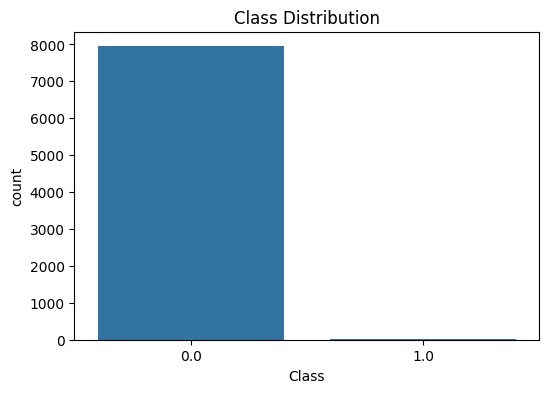

In [27]:
plt.figure(figsize=(6, 4))
sns.countplot(x='Class', data=df)
plt.title("Class Distribution")
plt.show()

In [28]:
df['Amount'].describe()

,Amount
count,7972.000000
mean,65.413540
std,194.911169
min,0.000000
25%,4.617500
50%,15.950000
75%,54.910000
max,7712.430000


####Data preprocesing and train test split

In [29]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [30]:
df["Amount_Scaled"] = StandardScaler().fit_transform(df["Amount"].values.reshape(-1, 1))

In [31]:
df = df.drop(["Time", "Amount"], axis=1)

In [33]:
X = df.drop("Class", axis=1)
y = df["Class"]

print(X.shape)
print(y.shape)

(7972, 29)
(7972,)


In [35]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print("X_train: ", X_train.shape)
print("X_test: ", X_test.shape)
print("y_train: ", y_train.shape)
print("y_test: ", y_test.shape)

X_train:  (6377, 29)
X_test:  (1595, 29)
y_train:  (6377,)
y_test:  (1595,)
